# Implicit performance improvements when plotting raster data

This notebook illustrates how performant rendering (enabled by default) is achieved in `spatialdata-plot` when rendering images/labels and what to consider when plotting multiscale-images/-labels. A heuristic approach is used to achieve fast rendering times, however, there are multiple ways to change the default behavior.

The example dataset can be downloaded here: [Visium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip). Please rename the file to `visium.zarr` and place it in the same folder as this notebook (or use symlinks to make the data accessible).

In [1]:
import warnings

import matplotlib.pyplot as plt
import spatialdata as sd
import spatialdata_plot

warnings.filterwarnings("ignore")

In [2]:
sdata = sd.read_zarr("visium.zarr")
sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (4992, 18085)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_hires_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
▸ 'downscaled_lowres', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_lowres_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Sha

## 1 Single-Scale Images

A single-scale image is a simple, single image with values in a grid. On the other hand, a `SpatialData` object can include multi-scale images that are composed of multiple single-scale images at different scales. All of those single-scale images show the same picture, just at different resolutions (the underlying grids differ). Therefore, one single-scale image can include more details when plotted compared to another single-scale image belonging to the same multi-scale image while having a larger size and higher rendering times.

An image or label can either be single- or multi-scale and the rendering process differs slightly. For a multi-scale image or label, one of the single scales has to be chosen initially in order to get a renderable image which is then treated like a single-scale image. For a single-scale image, one does not have the option to select a scale, but decreasing the resolution in order to increase the runtime is still possible by downsampling the image.

### 1.1 Default Behavior

INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'aligned' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 264 ms, sys: 15.7 ms, total: 279 ms
Wall time: 373 ms


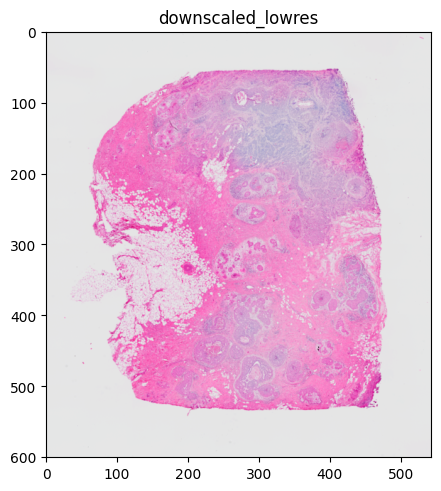

In [3]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_lowres_image").pl.show()

When necessary, the image is rasterized to improve performance. Here, the image is downsampled which leads to a lower resolution. This is especially important when the size of the rendering device is smaller than the size of the image to render. In this case, rendering the full image instead of the rasterized one would not lead to a better result while having longer rendering times. Under the hood, a heuristic using image extent, dpi and size of the rendering device determines the necessity of rasterization.

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'aligned' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 403 ms, sys: 275 ms, total: 678 ms
Wall time: 413 ms


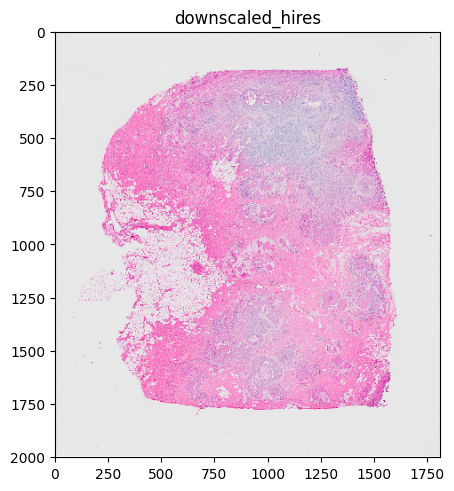

In [4]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_hires_image").pl.show()
# the image is automatically rasterized before rendering

### 1.2 Options

The user can set image size and dpi with the `dpi` and `figisze` parameters of `pl.show()`. These parameters also have an influence on the rasterization! For example, if an image is automatically rasterized, because its size is larger than that of the rendering device, the rasterization is not performed anymore after the `figsize` is increased to a value larger than the image size. The reason for this is that `dpi` and `figsize` are part of the heuristic that is used to decide if rasterization is necessary.

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'aligned' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 635 ms, sys: 256 ms, total: 891 ms
Wall time: 619 ms


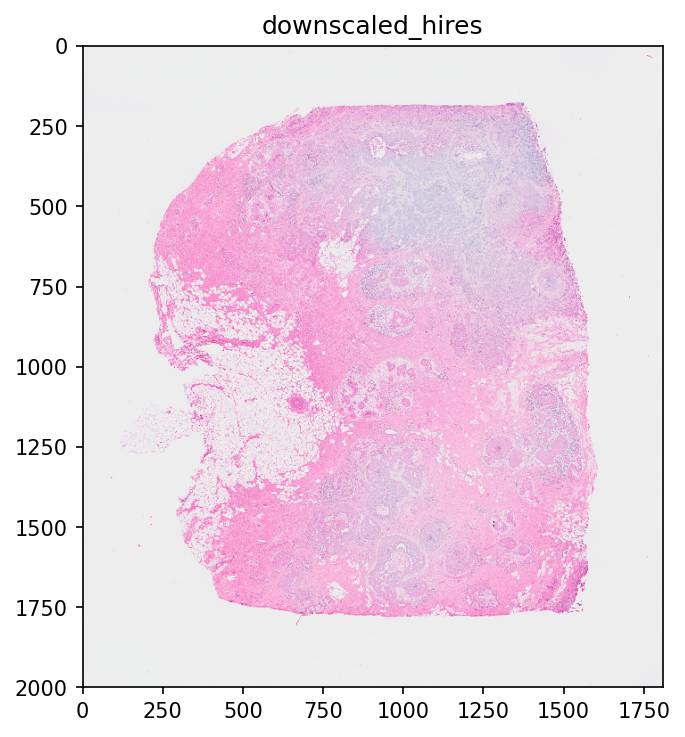

In [5]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_hires_image").pl.show(dpi=150)
# the image is automatically rasterized before rendering

One can also alter the `dpi` and `figsize` parameters in `plt.figure()` or `plt.subplots()` which can be seen in the following.

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'aligned' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 271 ms, sys: 227 ms, total: 498 ms
Wall time: 233 ms


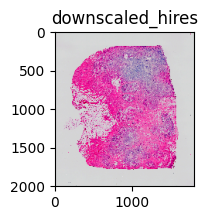

In [6]:
%%time
fig, axs = plt.subplots(ncols=1, figsize=(2, 2))
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_hires_image").pl.show(ax=axs)

In order to disable the rasterization of an image, one can set `scale="full"` in `pl.render_images()` or `pl.render_labels()`. Note, that depending on the image size, this can lead to long rendering times. In this case, the image size is not large enough to lead to a "too long" runtime. See a more drastic effect of disabling the rasterization in part 2 (the multi-scale image contains a larger image).

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'aligned' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 235 ms, sys: 126 ms, total: 361 ms
Wall time: 278 ms


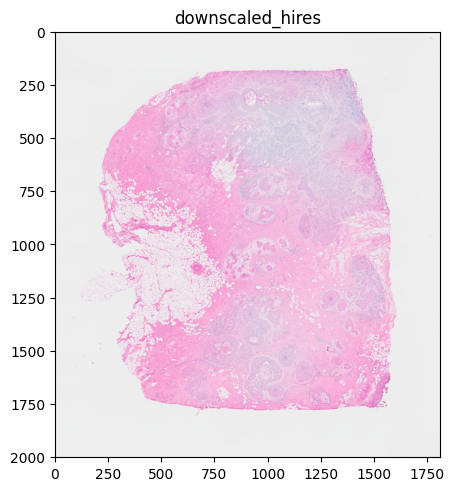

In [7]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_hires_image", scale="full").pl.show()

## 2 Multi-Scale Images

### 2.1 Default Behavior

Per default, the scale that fits the size of the rendering device best is automatically selected. From there on, the selected scale is treated like a single-scale image (e.g. if necessary, a rasterization step is added to speed up the rendering process).

In the example here: `scale4` (the scale with the lowest resolution) was automatically selected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 269 ms, sys: 70.9 ms, total: 339 ms
Wall time: 298 ms


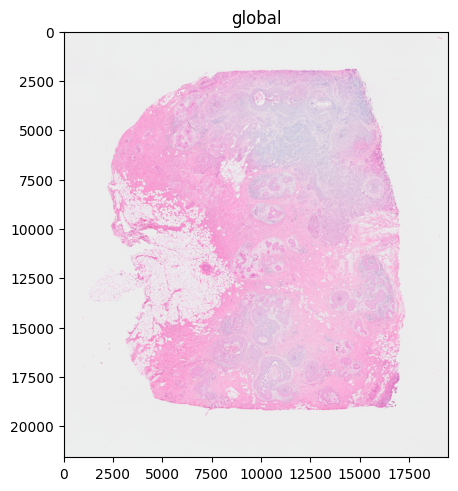

In [8]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image").pl.show("global")
# "scale4" is automatically selected

### 2.2 Options

As always, image size and dpi can be regulated via the `dpi` and `figsize` parameters of `pl.show()`. Those parameters also affect the scale selection!

The example below shows that when choosing a higher `dpi`, a scale with higher resolution is selected automatically (`scale3` in this case). Also, a rasterization step was performed to speed up the performance (just as it would happen with a single-scale image). It is the normal behavior that when the "optimal" scale lies between two existing scales, the one with higher resolution is selected and if necessary, the image is rasterized to speed up the rendering. Else, the resulting resolution could be lower than the "optimal" one.

The same behavior could have been achieved with e.g. `dpi=300`.

CPU times: user 1min 51s, sys: 2.67 s, total: 1min 54s
Wall time: 20.9 s


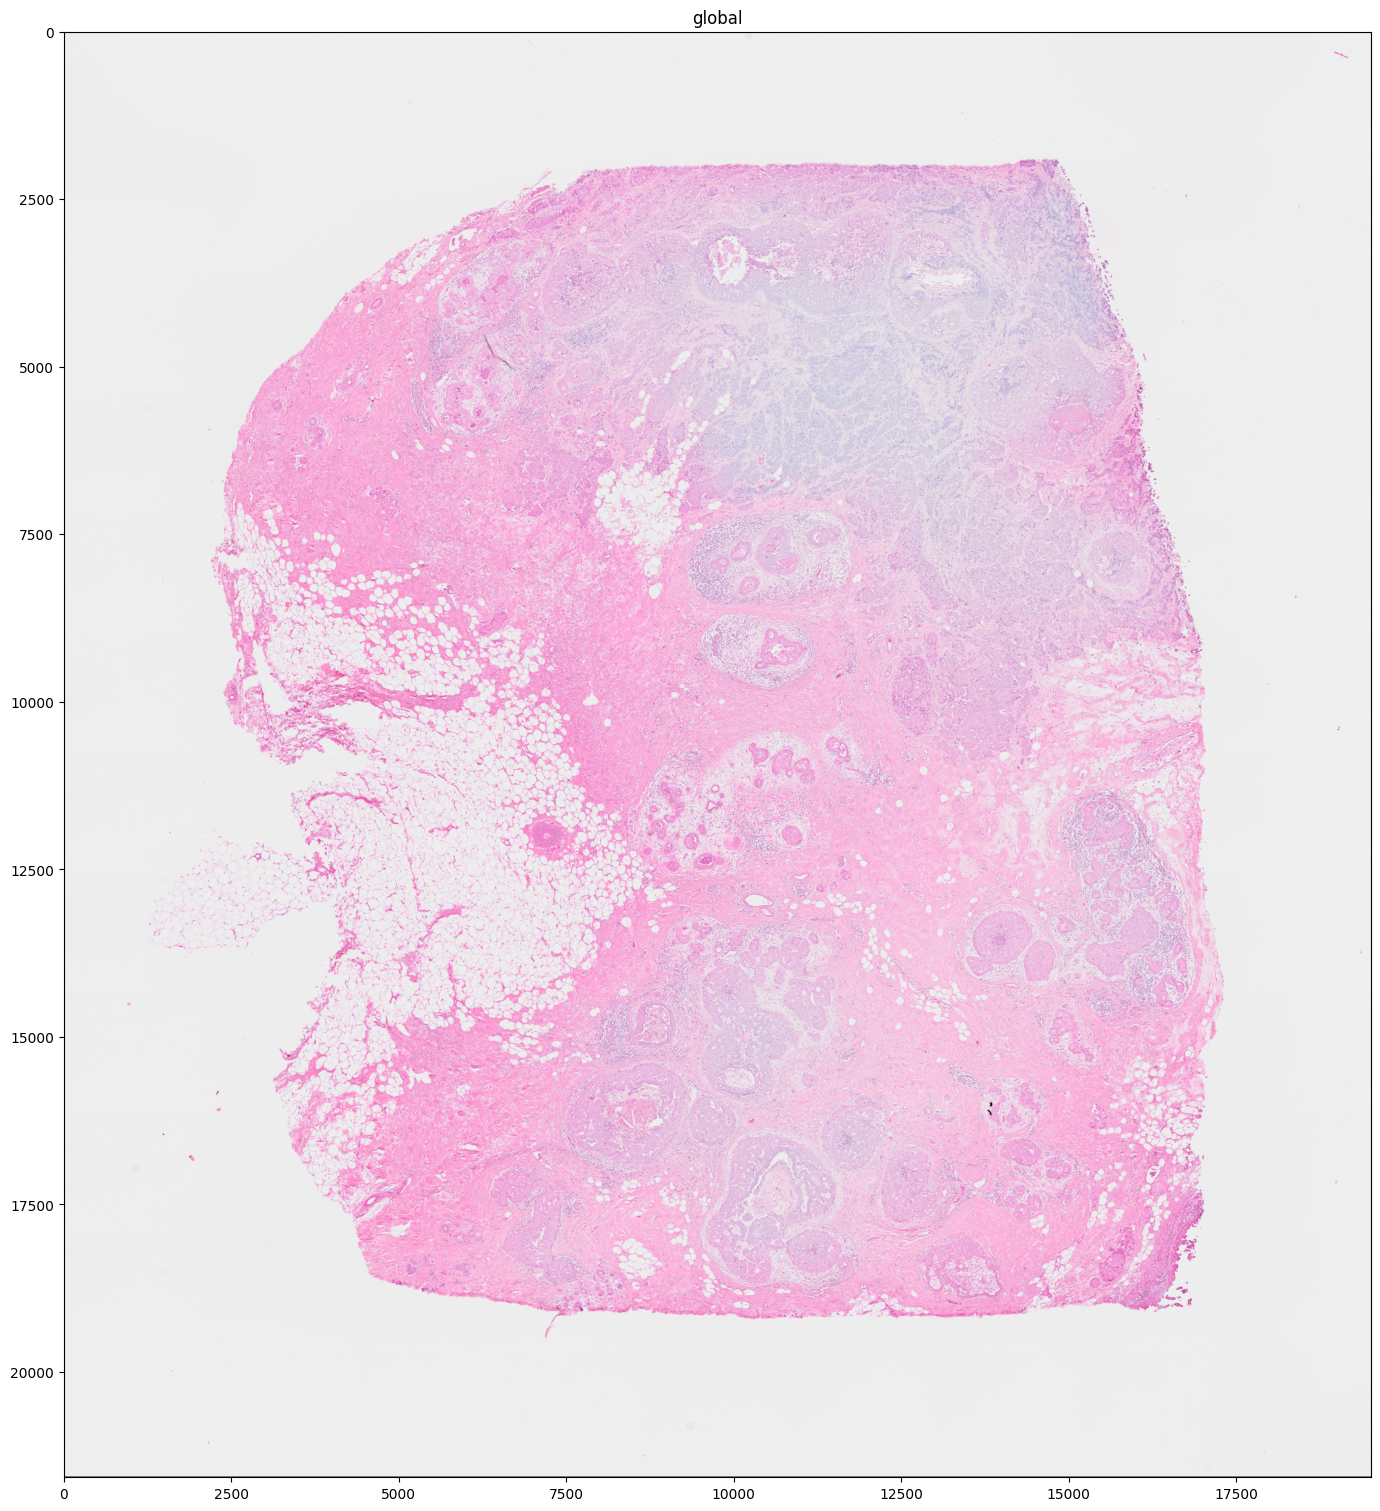

In [9]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image").pl.show("global", figsize=(15.0, 15.0))
# "scale3" is automatically selected and the image is automatically rasterized before rendering

The user can also select a specific scale to be rendered using the `scale` argument of `pl.render_images()` or `pl.render_labels()`.

Note, that when a specific scale is selected, no rasterization will be performed, unless: `dpi` or `figsize` are specified by the user in `pl.show()`. This re-enables the rasterization if neccessary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 631 ms, sys: 184 ms, total: 815 ms
Wall time: 693 ms


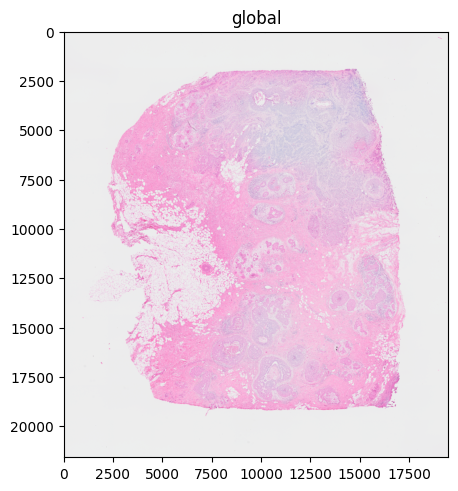

In [10]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image", scale="scale3").pl.show("global")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 652 ms, sys: 166 ms, total: 818 ms
Wall time: 694 ms


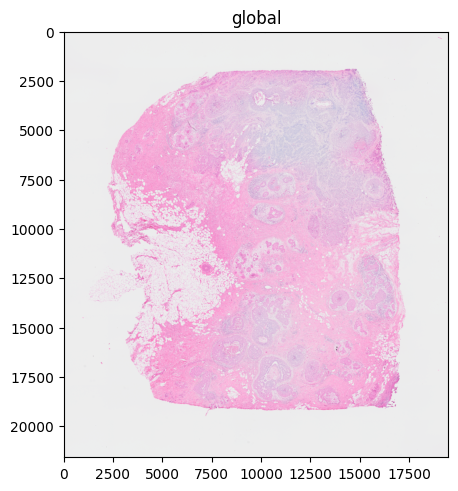

In [11]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image", scale="scale3").pl.show("global", dpi=100)
# the image is automatically rasterized before rendering

Below, you can see an example where the scale with the highest resolution was selected but the overall plot should have a `dpi` of 100. This leads to a drastic rasterization which is computationally demanding, which exemplifies that care should be taken when specifing both scale and dpi/figsize at the same time. Here plotting from a lower scale and leaving the `dpi` parameter to its default value would have led to plot with comparable image quality but faster rendering time. Note that we plot a cropped version of the data to reduce the notebook execution time.

In [42]:
sdata_cropped = sdata.query.bounding_box(
    min_coordinate=[0, 0], max_coordinate=[10000, 10000], axes=("x", "y"), target_coordinate_system="global"
)

CPU times: user 14.5 s, sys: 9.76 s, total: 24.3 s
Wall time: 20.8 s


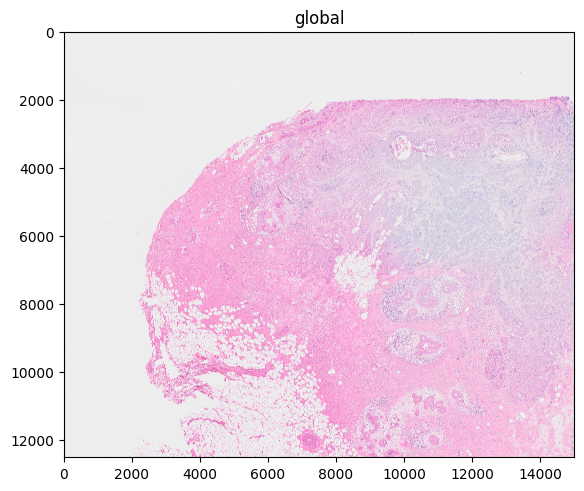

In [43]:
%%time
sdata_cropped.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image", scale="scale0").pl.show(
    "global", dpi=100
)
# the image is automatically rasterized before rendering

Setting `scale="full"` in `pl.render_images()` or `pl.render_labels()` will lead to the scale with highest resolution being selected and no rasterization being performed. Depending on resolution/image size this can lead to long rendering times! In this case, we are looking at the largest image in the SpatialData object ("scale0"). Depending on the machine, the rendering might also run into a memory error which is why the version with `scale="full"` is not included here. Instead, `scale="scale1"` is used here to demonstrate high rendering times for images with high resolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 3.97 s, sys: 1.49 s, total: 5.46 s
Wall time: 4.76 s


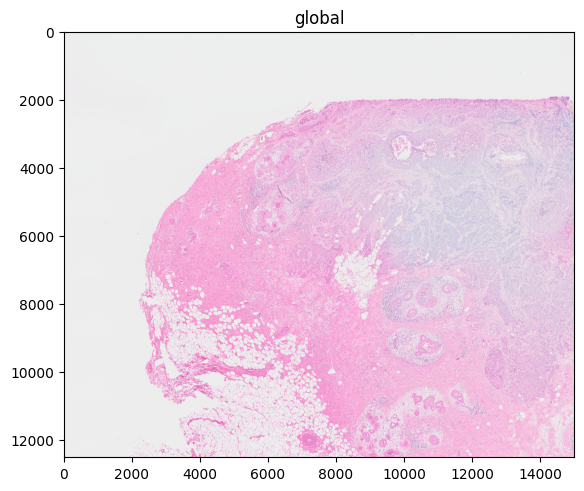

In [44]:
%%time
sdata_cropped.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image", scale="scale1").pl.show("global")
# using the second highest resolution